In [4]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from typing import Tuple, List
import random
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: MPS


### Question 4.1

In [6]:
# 4.1.1 Dataset Generation
def generate_sequences(num_sequences, min_length=1, max_length=16):
    sequences = []
    counts = []
    
    for _ in range(num_sequences):
        length = np.random.randint(min_length, max_length + 1)
        sequence = np.random.randint(0, 2, size=length)
        count = np.sum(sequence)
        sequences.append(sequence)
        counts.append(count)
    
    return sequences, counts

class BitCountDataset(Dataset):
    def __init__(self, sequences, counts):
        self.sequences = sequences
        self.counts = counts
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.FloatTensor(self.sequences[idx])
        count = torch.FloatTensor([self.counts[idx]])
        return seq, count

def collate_fn(batch):
    # Separate sequences and counts
    sequences = [item[0] for item in batch]
    counts = [item[1] for item in batch]
    
    # Pad sequences to the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    counts = torch.stack(counts)
    
    return sequences_padded, counts

# Generate dataset
sequences, counts = generate_sequences(100000)

# Split dataset
train_seq, temp_seq, train_counts, temp_counts = train_test_split(sequences, counts, test_size=0.2, random_state=42)
val_seq, test_seq, val_counts, test_counts = train_test_split(temp_seq, temp_counts, test_size=0.5, random_state=42)

# Create datasets
train_dataset = BitCountDataset(train_seq, train_counts)
val_dataset = BitCountDataset(val_seq, val_counts)
test_dataset = BitCountDataset(test_seq, test_counts)

# Create dataloaders with collate_fn
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# 4.1.2 RNN Architecture
class BitCountRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(BitCountRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = x.unsqueeze(-1) if x.dim() == 2 else x  # Add feature dimension
        output, _ = self.rnn(x)
        return self.fc(output[:, -1, :])

# 4.1.3 Training Loop
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, counts in train_loader:
            sequences, counts = sequences.to(device), counts.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, counts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, counts in val_loader:
                sequences, counts = sequences.to(device), counts.to(device)
                outputs = model(sequences)
                val_loss += criterion(outputs, counts).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training MAE: {train_loss:.4f}')
        print(f'Validation MAE: {val_loss:.4f}')
    
    return train_losses, val_losses

# Random baseline
def random_baseline(sequences, counts):
    predictions = [np.random.randint(0, len(seq)+1) for seq in sequences]
    mae = np.mean(np.abs(np.array(predictions) - np.array(counts)))
    return mae

# 4.1.4 Generalization Test
def test_generalization(model, max_length=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    mae_by_length = {}
    
    for length in range(1, max_length + 1):
        # Generate test sequences of specific length
        test_sequences, test_counts = generate_sequences(1000, length, length)
        test_dataset = BitCountDataset(test_sequences, test_counts)
        test_loader = DataLoader(test_dataset, batch_size=32)
        
        total_mae = 0
        with torch.no_grad():
            for sequences, counts in test_loader:
                sequences, counts = sequences.to(device), counts.to(device)
                outputs = model(sequences)
                mae = nn.L1Loss()(outputs, counts).item()
                total_mae += mae
        
        mae_by_length[length] = total_mae / len(test_loader)
    
    return mae_by_length

Starting training...
Epoch 1/20:
Training MAE: 0.5064
Validation MAE: 0.0772
Epoch 2/20:
Training MAE: 0.1171
Validation MAE: 0.1387
Epoch 3/20:
Training MAE: 0.0883
Validation MAE: 0.0322
Epoch 4/20:
Training MAE: 0.0668
Validation MAE: 0.0325
Epoch 5/20:
Training MAE: 0.0479
Validation MAE: 0.0219
Epoch 6/20:
Training MAE: 0.0358
Validation MAE: 0.0174
Epoch 7/20:
Training MAE: 0.0294
Validation MAE: 0.0380
Epoch 8/20:
Training MAE: 0.0242
Validation MAE: 0.0126
Epoch 9/20:
Training MAE: 0.0249
Validation MAE: 0.0268
Epoch 10/20:
Training MAE: 0.0183
Validation MAE: 0.0083
Epoch 11/20:
Training MAE: 0.0408
Validation MAE: 0.0098
Epoch 12/20:
Training MAE: 0.0147
Validation MAE: 0.0107
Epoch 13/20:
Training MAE: 0.0200
Validation MAE: 0.0097
Epoch 14/20:
Training MAE: 0.0112
Validation MAE: 0.0074
Epoch 15/20:
Training MAE: 0.0097
Validation MAE: 0.0082
Epoch 16/20:
Training MAE: 0.0166
Validation MAE: 0.0140
Epoch 17/20:
Training MAE: 0.0174
Validation MAE: 0.0054
Epoch 18/20:
Traini

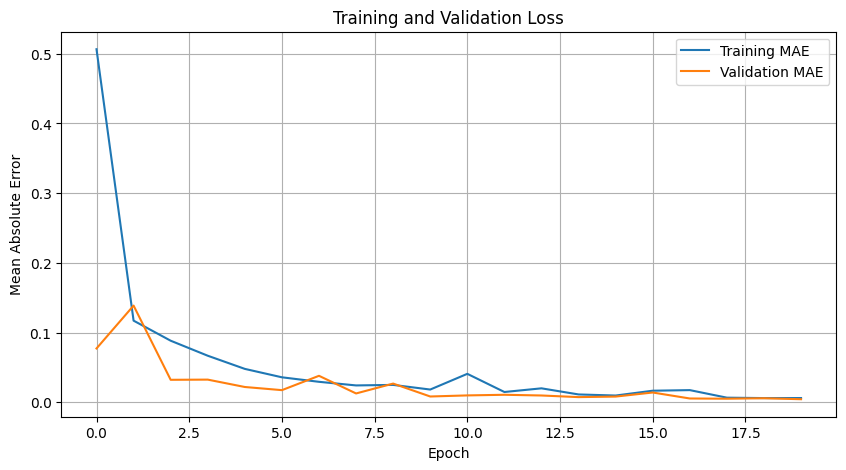


Calculating random baseline...
Random Baseline MAE: 2.5557

Testing generalization...


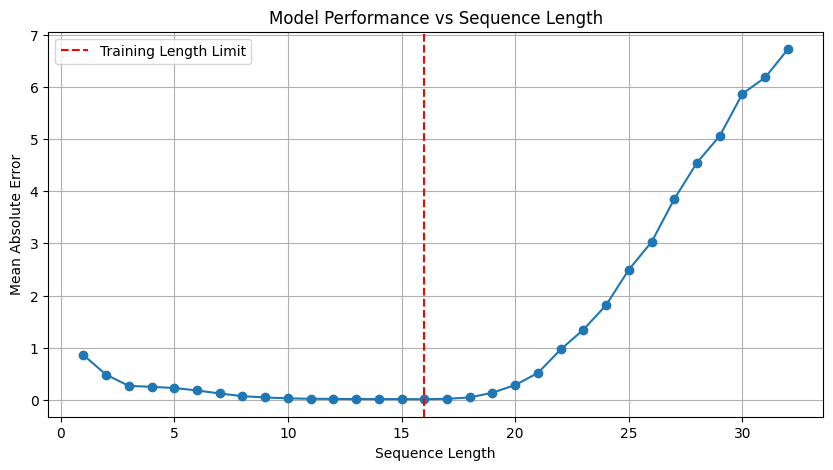


Example predictions:
Sequence: [1 1]
True count: 2
Predicted count: 2.85
Absolute Error: 0.85

Sequence: [0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0]
True count: 8
Predicted count: 8.00
Absolute Error: 0.00

Sequence: [1 1 0 0 1]
True count: 3
Predicted count: 2.70
Absolute Error: 0.30

Sequence: [1 1]
True count: 2
Predicted count: 2.85
Absolute Error: 0.85

Sequence: [0 0 0 0 1 1 0]
True count: 2
Predicted count: 2.20
Absolute Error: 0.20

Model saved successfully!


In [ ]:
if __name__ == "__main__":
    # Initialize model
    model = BitCountRNN().to(device)
    
    # Train model
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)
    print("Training completed!")
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training MAE')
    plt.plot(val_losses, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curves.png')
    plt.show()
    
    # Calculate random baseline
    print("\nCalculating random baseline...")
    baseline_mae = random_baseline(test_seq, test_counts)
    print(f'Random Baseline MAE: {baseline_mae:.4f}')
    
    # Test generalization
    print("\nTesting generalization...")
    mae_by_length = test_generalization(model)
    
    # Plot generalization results
    plt.figure(figsize=(10, 5))
    lengths = list(mae_by_length.keys())
    maes = list(mae_by_length.values())
    plt.plot(lengths, maes, marker='o')
    plt.axvline(x=16, color='r', linestyle='--', label='Training Length Limit')
    plt.xlabel('Sequence Length')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance vs Sequence Length')
    plt.legend()
    plt.grid(True)
    plt.savefig('generalization_results.png')
    plt.show()

    # Print some example predictions
    print("\nExample predictions:")
    model.eval()
    # Move model to CPU for predictions
    model = model.cpu()
    with torch.no_grad():
        for i in range(5):
            seq = test_seq[i]
            true_count = test_counts[i]
            # Process on CPU
            seq_tensor = torch.FloatTensor(seq).unsqueeze(0)
            try:
                pred = model(seq_tensor)
                print(f'Sequence: {seq}')
                print(f'True count: {true_count}')
                print(f'Predicted count: {pred.item():.2f}')
                print(f'Absolute Error: {abs(pred.item() - true_count):.2f}\n')
            except RuntimeError as e:
                print(f"Error processing sequence {i}: {e}")
                continue

    # Save the model
    try:
        torch.save(model.state_dict(), '53_bit_counting_model.pth')
        print("Model saved successfully!")
    except Exception as e:
        print(f"Error saving model: {e}")

### Question 4.2